# Bike-Sharing Dataset

The [Bike-Sharing Dataset](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset) contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information. The dataset contains 14 features with information about the day-type, e.g., month, hour, which day of the week, whether it is working-day, and the weather conditions, e.g., temperature, humidity, wind speed, etc. The target variable is the number of bike rentals per hour. The dataset contains 17,379 instances. 

In [1]:
import effector
import numpy as np
import tensorflow as tf
from tensorflow import keras
import random

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

2025-02-26 11:04:59.976580: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Preprocess the data

In [2]:
from ucimlrepo import fetch_ucirepo 

bike_sharing_dataset = fetch_ucirepo(id=275) 
X = bike_sharing_dataset.data.features 
y = bike_sharing_dataset.data.targets 

In [3]:
X = X.drop(["dteday", "atemp"], axis=1)

In [4]:
X.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed
0,1,0,1,0,0,6,0,1,0.24,0.81,0.0
1,1,0,1,1,0,6,0,1,0.22,0.80,0.0
2,1,0,1,2,0,6,0,1,0.22,0.80,0.0
3,1,0,1,3,0,6,0,1,0.24,0.75,0.0
4,1,0,1,4,0,6,0,1,0.24,0.75,0.0


In [5]:
print("Design matrix shape: {}".format(X.shape))
print("---------------------------------")
for col_name in X.columns:
    print("Feature: {:15}, unique: {:4d}, Mean: {:6.2f}, Std: {:6.2f}, Min: {:6.2f}, Max: {:6.2f}".format(col_name, len(X[col_name].unique()), X[col_name].mean(), X[col_name].std(), X[col_name].min(), X[col_name].max()))
    
print("\nTarget shape: {}".format(y.shape))
print("---------------------------------")
for col_name in y.columns:
    print("Target: {:15}, unique: {:4d}, Mean: {:6.2f}, Std: {:6.2f}, Min: {:6.2f}, Max: {:6.2f}".format(col_name, len(y[col_name].unique()), y[col_name].mean(), y[col_name].std(), y[col_name].min(), y[col_name].max()))

Design matrix shape: (17379, 11)
---------------------------------
Feature: season         , unique:    4, Mean:   2.50, Std:   1.11, Min:   1.00, Max:   4.00
Feature: yr             , unique:    2, Mean:   0.50, Std:   0.50, Min:   0.00, Max:   1.00
Feature: mnth           , unique:   12, Mean:   6.54, Std:   3.44, Min:   1.00, Max:  12.00
Feature: hr             , unique:   24, Mean:  11.55, Std:   6.91, Min:   0.00, Max:  23.00
Feature: holiday        , unique:    2, Mean:   0.03, Std:   0.17, Min:   0.00, Max:   1.00
Feature: weekday        , unique:    7, Mean:   3.00, Std:   2.01, Min:   0.00, Max:   6.00
Feature: workingday     , unique:    2, Mean:   0.68, Std:   0.47, Min:   0.00, Max:   1.00
Feature: weathersit     , unique:    4, Mean:   1.43, Std:   0.64, Min:   1.00, Max:   4.00
Feature: temp           , unique:   50, Mean:   0.50, Std:   0.19, Min:   0.02, Max:   1.00
Feature: hum            , unique:   89, Mean:   0.63, Std:   0.19, Min:   0.00, Max:   1.00
Feature: wind

In [6]:
def preprocess(X, y):
    # Standarize X
    X_df = X
    x_mean = X_df.mean()
    x_std = X_df.std()
    X_df = (X_df - X_df.mean()) / X_df.std()

    # Standarize Y
    Y_df = y
    y_mean = Y_df.mean()
    y_std = Y_df.std()
    Y_df = (Y_df - Y_df.mean()) / Y_df.std()
    return X_df, Y_df, x_mean, x_std, y_mean, y_std

# shuffle and standarize all features
X_df, Y_df, x_mean, x_std, y_mean, y_std = preprocess(X, y)

In [7]:
def split(X_df, Y_df):
    # shuffle indices
    indices = X_df.index.tolist()
    np.random.shuffle(indices)
    
    # data split
    train_size = int(0.8 * len(X_df))
    
    X_train = X_df.iloc[indices[:train_size]]
    Y_train = Y_df.iloc[indices[:train_size]]
    X_test = X_df.iloc[indices[train_size:]]
    Y_test = Y_df.iloc[indices[train_size:]]
    
    return X_train, Y_train, X_test, Y_test

# train/test split
X_train, Y_train, X_test, Y_test = split(X_df, Y_df)


## Fit a Neural Network

In [8]:
# Train - Evaluate - Explain a neural network
model = keras.Sequential([
    keras.layers.Dense(1024, activation="relu"),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mse", metrics=["mae", keras.metrics.RootMeanSquaredError()])
model.fit(X_train, Y_train, batch_size=512, epochs=20, verbose=1)
model.evaluate(X_train, Y_train, verbose=1)
model.evaluate(X_test, Y_test, verbose=1)


Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.6231 - mae: 0.5745 - root_mean_squared_error: 0.7853
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3870 - mae: 0.4506 - root_mean_squared_error: 0.6219
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2976 - mae: 0.3851 - root_mean_squared_error: 0.5454
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2237 - mae: 0.3326 - root_mean_squared_error: 0.4728
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1619 - mae: 0.2836 - root_mean_squared_error: 0.4023
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1193 - mae: 0.2386 - root_mean_squared_error: 0.3451
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0906 - mae: 0.2075 - root_mean_squared_error: 0.3009
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0753 - mae: 0.1895 - root_mean_squared_error: 0.2745
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0669 - mae: 0.1784 - root_m

[0.06317276507616043, 0.16644978523254395, 0.25134193897247314]

We train a deep fully-connected Neural Network with 3 hidden layers for \(20\) epochs. 
The model achieves a root mean squared error on the test of about $0.24$ units, that corresponds to approximately \(0.26 * 181 = 47\) counts.

## Explain

We will focus on the feature `temp` (temperature) because its global effect is quite heterogeneous and the heterogeneity can be further explained using regional effects.

In [9]:
def model_jac(x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        pred = model(x_tensor)
        grads = t.gradient(pred, x_tensor)
    return grads.numpy()

def model_forward(x):
    return model(x).numpy().squeeze()

In [10]:
scale_y = {"mean": y_mean.iloc[0], "std": y_std.iloc[0]}
scale_x_list =[{"mean": x_mean.iloc[i], "std": x_std.iloc[i]} for i in range(len(x_mean))]
scale_x = scale_x_list[3]
feature_names = X_df.columns.to_list()
target_name = "bike-rentals"
y_limits=[-200, 800]
dy_limits = [-300, 300]

In [11]:
scale_x_list[8]["mean"] += 8
scale_x_list[8]["std"] *= 47

scale_x_list[9]["std"] *= 100
scale_x_list[10]["std"] *= 67

## Global Effect  

**Overview of All Features**

We start by examining all relevant features. Feature effect methods are generally more meaningful for numerical features. To compare effects across features more easily, we standardize the `y_limits`.  

Relevant features:

- `month`  
- `hr`  
- `weekday`  
- `workingday`  
- `temp`  
- `humidity`  
- `windspeed` 

We observe that features: `hour`, `temperature` and `humidity` have an intersting structure. Out of them `hour` has by far the most influence on the output, so it makes sensce to fucse on it further.

2025-02-26 11:05:19.691215: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 245760000 exceeds 10% of free system memory.
2025-02-26 11:05:19.739214: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 245760000 exceeds 10% of free system memory.
2025-02-26 11:05:19.779244: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 245760000 exceeds 10% of free system memory.
2025-02-26 11:05:20.164766: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 245760000 exceeds 10% of free system memory.
2025-02-26 11:05:20.211132: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 245760000 exceeds 10% of free system memory.


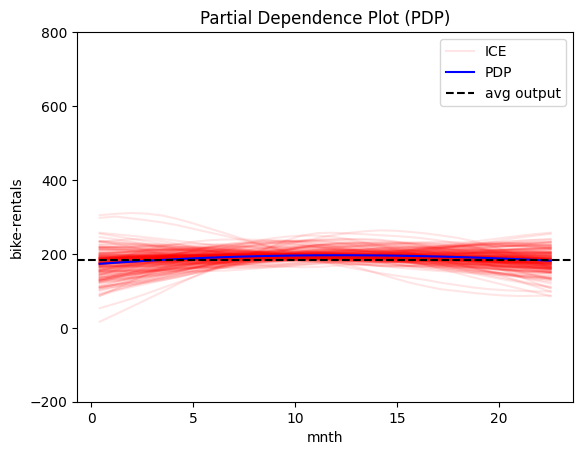

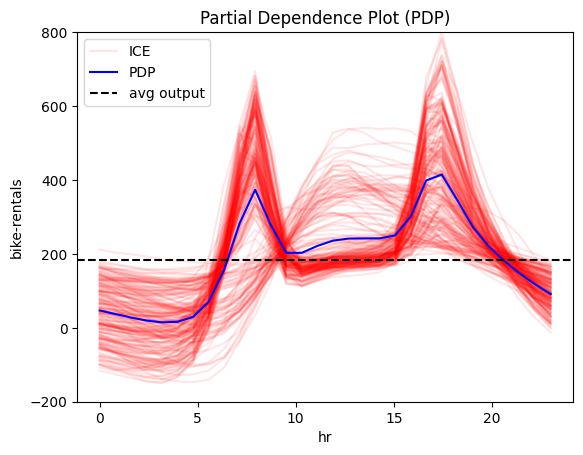

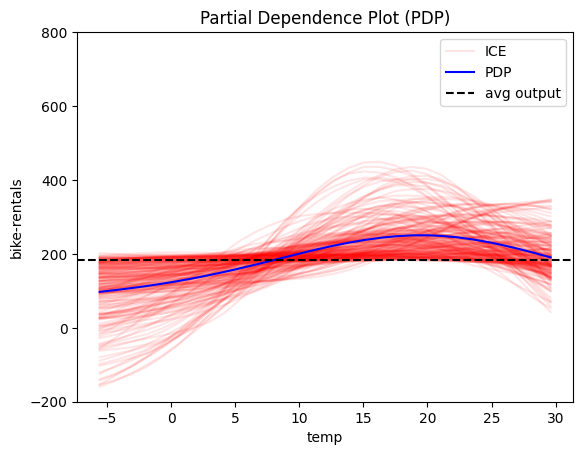

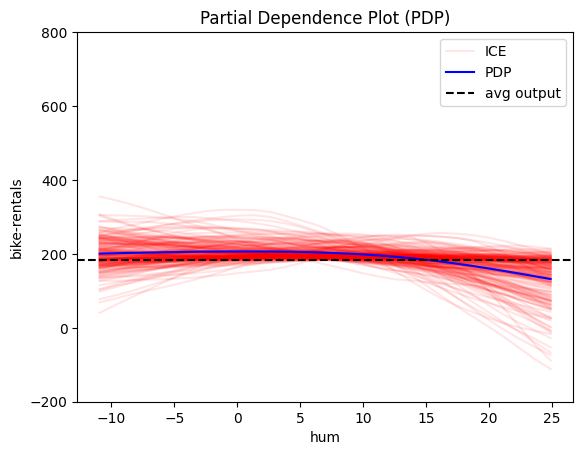

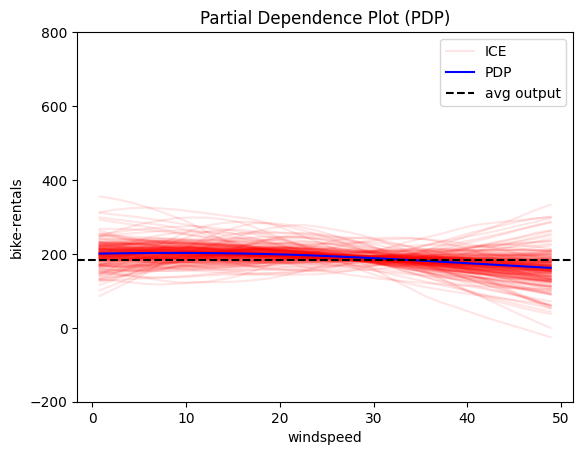

In [12]:
pdp = effector.PDP(data=X_train.to_numpy(), model=model_forward, feature_names=feature_names, target_name=target_name, nof_instances=2000)
for i in [2, 3, 8, 9, 10]:
    pdp.plot(feature=i, centering=True, scale_x=scale_x, scale_y=scale_y, show_avg_output=True, nof_ice=200, y_limits=y_limits)

### PDP 

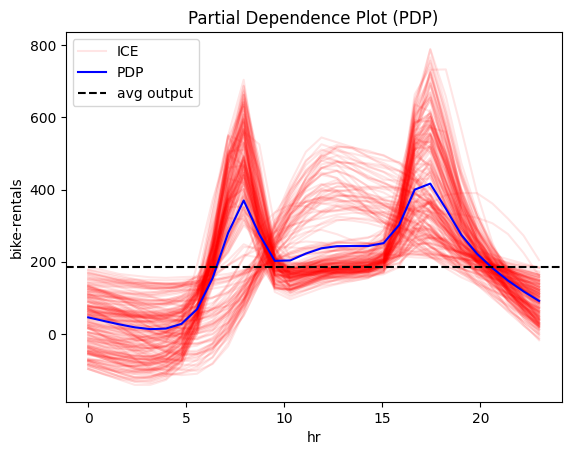

In [13]:
pdp = effector.PDP(data=X_train.to_numpy(), model=model_forward, feature_names=feature_names, target_name=target_name, nof_instances=5000)
pdp.plot(feature=3, centering=True, scale_x=scale_x, scale_y=scale_y, show_avg_output=True, nof_ice=200)

### RHALE

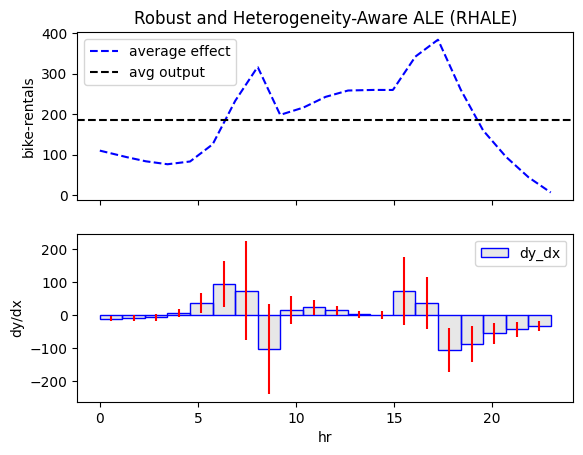

In [14]:
rhale = effector.RHALE(data=X_train.to_numpy(), model=model_forward, model_jac=model_jac, feature_names=feature_names, target_name=target_name)
rhale.plot(feature=3, heterogeneity="std", centering=True, scale_x=scale_x, scale_y=scale_y, show_avg_output=True)

PermutationExplainer explainer: 501it [02:44,  2.91it/s]                         


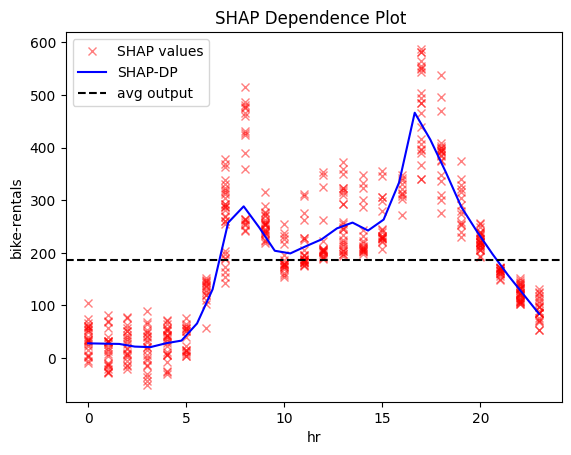

In [15]:
shap_dp = effector.ShapDP(data=X_train.to_numpy(), model=model_forward, feature_names=feature_names, target_name=target_name, nof_instances=500)
shap_dp.plot(feature=3, centering=True, scale_x=scale_x, scale_y=scale_y, show_avg_output=True)

### Conclusion  

All methods agree that `hour` affects `bike-rentals` with two peaks, around 8:00 and 17:00, likely reflecting commute hours. However, the effect varies significantly, so regional effects may help in understanding the origin of this heterogeneity.

## Regional Effect

### RegionalPDP

In [16]:
regional_pdp = effector.RegionalPDP(data=X_train.to_numpy(), model=model_forward, feature_names=feature_names, nof_instances=5_000)
regional_pdp.summary(features=3, scale_x_list=scale_x_list)

100%|██████████| 1/1 [00:01<00:00,  1.15s/it]



Feature 3 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
hr 🔹 [id: 0 | heter: 0.44 | inst: 5000 | w: 1.00]
    workingday = 0.00 🔹 [id: 1 | heter: 0.38 | inst: 1535 | w: 0.31]
        temp ≤ 6.81 🔹 [id: 3 | heter: 0.20 | inst: 774 | w: 0.15]
        temp > 6.81 🔹 [id: 4 | heter: 0.22 | inst: 761 | w: 0.15]
    workingday ≠ 0.00 🔹 [id: 2 | heter: 0.30 | inst: 3465 | w: 0.69]
        temp ≤ 6.81 🔹 [id: 5 | heter: 0.21 | inst: 1547 | w: 0.31]
        temp > 6.81 🔹 [id: 6 | heter: 0.21 | inst: 1918 | w: 0.38]
--------------------------------------------------
Feature 3 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 0.44
    Level 1🔹heter: 0.32 | 🔻0.12 (26.86%)
        Level 2🔹heter: 0.21 | 🔻0.12 (35.85%)




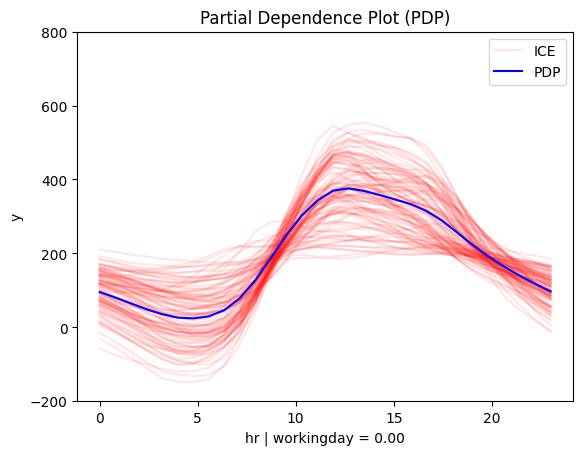

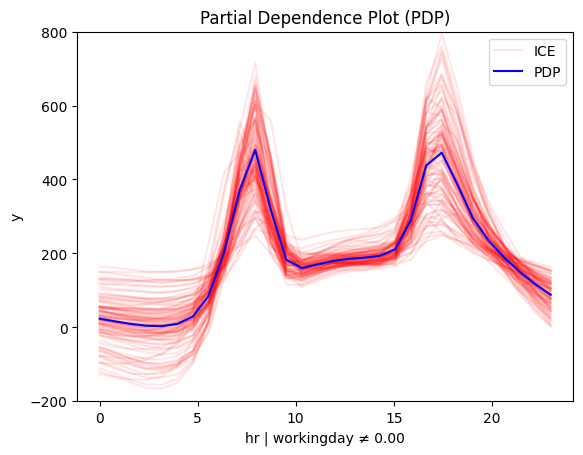

In [17]:
for node_idx in [1, 2]:
    regional_pdp.plot(feature=3, node_idx=node_idx, centering=True, scale_x_list=scale_x_list, scale_y=scale_y, y_limits=y_limits)

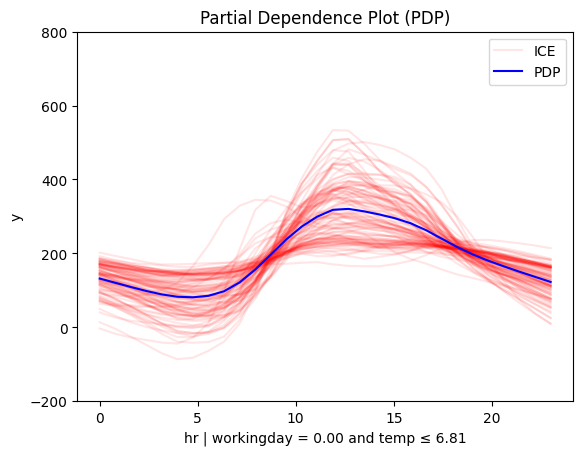

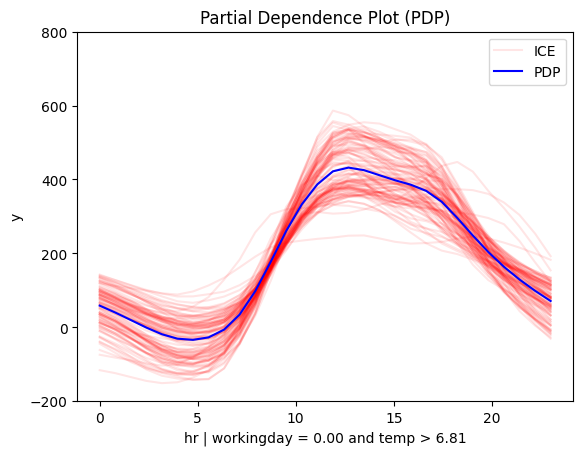

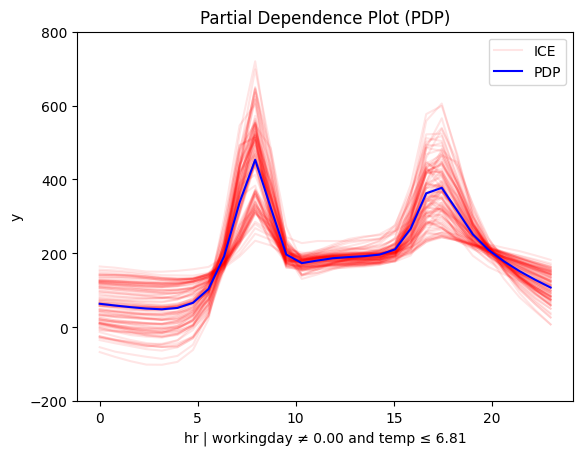

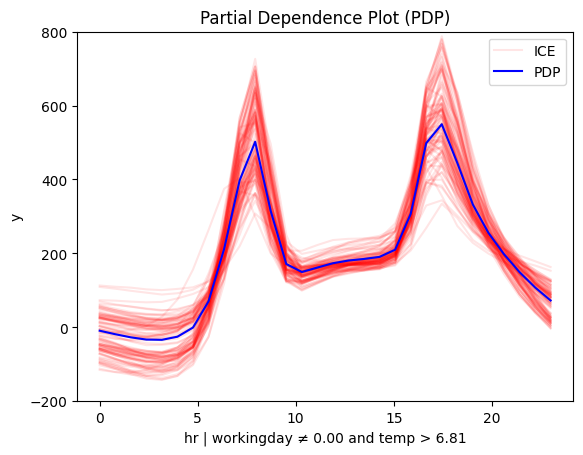

In [18]:
for node_idx in [3, 4, 5, 6]:
    regional_pdp.plot(feature=3, node_idx=node_idx, centering=True, scale_x_list=scale_x_list, scale_y=scale_y, y_limits=y_limits)

### RegionalRHALE

In [19]:
regional_rhale = effector.RegionalRHALE(data=X_train.to_numpy(), model=model_forward, model_jac=model_jac, feature_names=feature_names, target_name=target_name)
regional_rhale.summary(features=3, scale_x_list=scale_x_list)

100%|██████████| 1/1 [00:03<00:00,  3.19s/it]



Feature 3 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
hr 🔹 [id: 0 | heter: 5.68 | inst: 13903 | w: 1.00]
    workingday = 0.00 🔹 [id: 1 | heter: 0.75 | inst: 4385 | w: 0.32]
    workingday ≠ 0.00 🔹 [id: 2 | heter: 5.44 | inst: 9518 | w: 0.68]
--------------------------------------------------
Feature 3 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 5.68
    Level 1🔹heter: 3.96 | 🔻1.71 (30.22%)




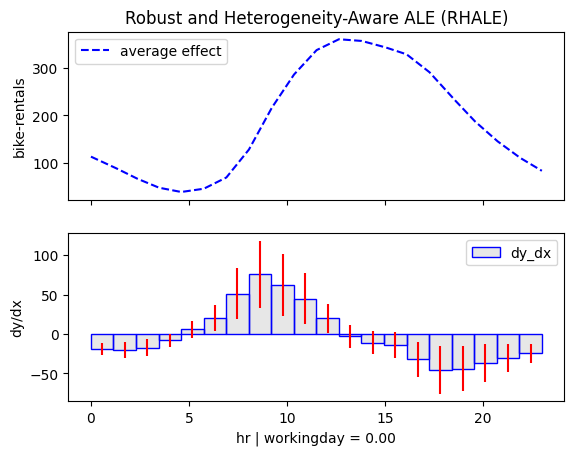

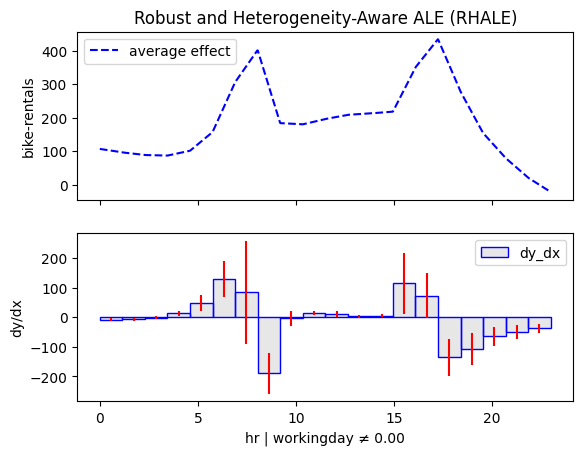

In [20]:
regional_rhale.plot(feature=3, node_idx=1, centering=True, scale_x_list=scale_x_list, scale_y=scale_y)
regional_rhale.plot(feature=3, node_idx=2, centering=True, scale_x_list=scale_x_list, scale_y=scale_y)

### Regional SHAP-DP

In [21]:
regional_shap_dp = effector.RegionalShapDP(data=X_train.to_numpy(), model=model_forward, feature_names=feature_names, nof_instances=500)

In [22]:
regional_shap_dp.summary(features=3, scale_x_list=scale_x_list)

PermutationExplainer explainer: 100%|██████████| 500/500 [02:56<00:00,  2.54it/s]
PermutationExplainer explainer: 501it [02:57,  2.65it/s]                         
100%|██████████| 1/1 [02:58<00:00, 178.25s/it]



Feature 3 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
hr 🔹 [id: 0 | heter: 0.06 | inst: 500 | w: 1.00]
    workingday = 0.00 🔹 [id: 1 | heter: 0.03 | inst: 150 | w: 0.30]
        temp ≤ 6.81 🔹 [id: 3 | heter: 0.01 | inst: 71 | w: 0.14]
        temp > 6.81 🔹 [id: 4 | heter: 0.02 | inst: 79 | w: 0.16]
    workingday ≠ 0.00 🔹 [id: 2 | heter: 0.04 | inst: 350 | w: 0.70]
        temp ≤ 6.81 🔹 [id: 5 | heter: 0.02 | inst: 150 | w: 0.30]
        temp > 6.81 🔹 [id: 6 | heter: 0.02 | inst: 200 | w: 0.40]
--------------------------------------------------
Feature 3 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 0.06
    Level 1🔹heter: 0.03 | 🔻0.03 (43.39%)
        Level 2🔹heter: 0.02 | 🔻0.02 (48.69%)




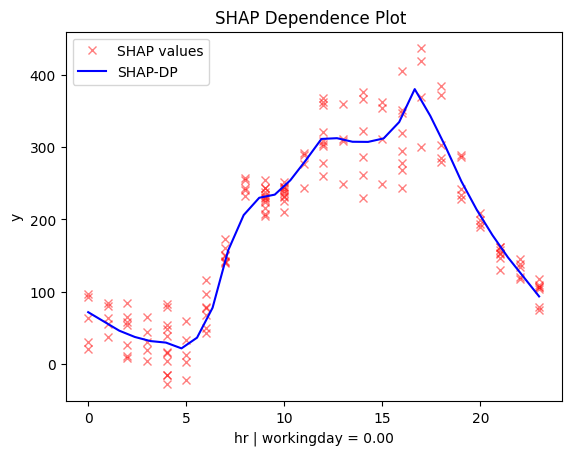

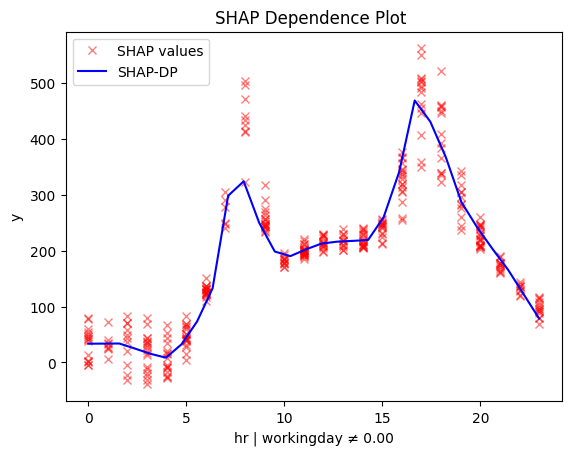

In [23]:
for node_idx in [1, 2]:
    regional_shap_dp.plot(feature=3, node_idx=node_idx, centering=True, scale_x_list=scale_x_list, scale_y=scale_y)

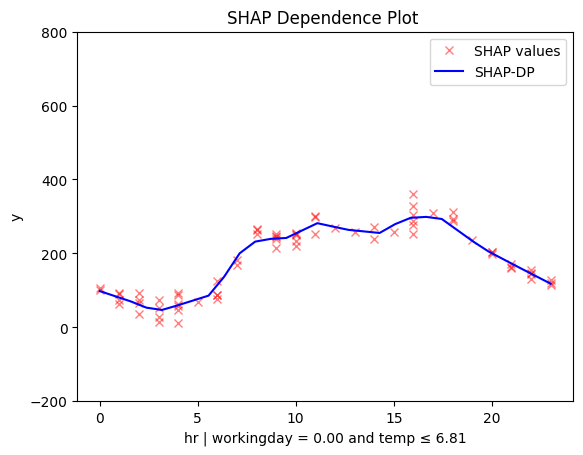

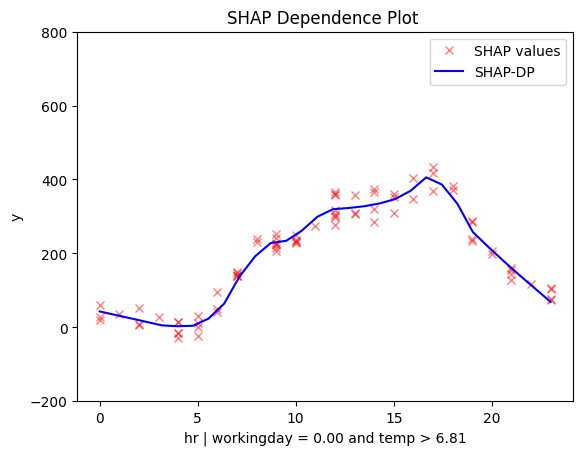

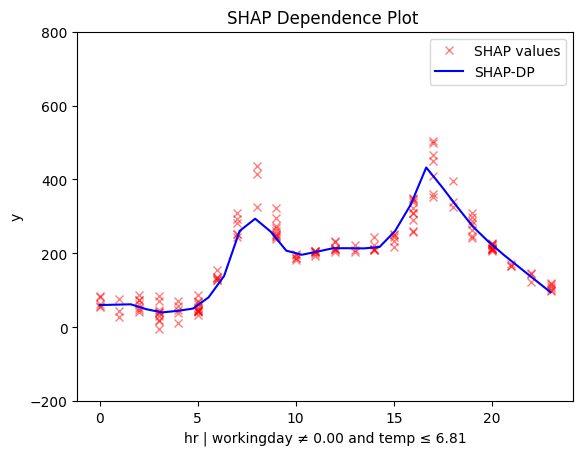

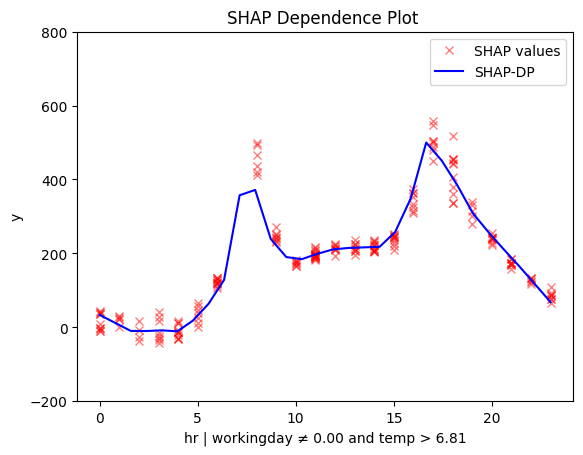

In [24]:
for node_idx in [3, 4, 5, 6]:
    regional_shap_dp.plot(feature=3, node_idx=node_idx, centering=True, scale_x_list=scale_x_list, scale_y=scale_y, y_limits=y_limits)

### Conclusion  

Regional methods reveal two distinct patterns: one for working days and another for non-working days.  

- On working days, the effect mirrors the global trend, with peaks around 8:00 and 17:00, likely due to commuting.  
- On non-working days, the pattern shifts to a single peak around 13:00, likely driven by sightseeing and leisure.  

PDP and ShapDP push it more; that on non-working days, `hour` interacts with `temperature` — peaks between 12:00 and 14:00 are more pronounced in warmer conditions. Makes sense, right? If you go for sightseeing, you probably 